# **Imports**

In [3]:
import cv2
import os
import copy
import numpy as np
import torch
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from tqdm import tqdm
from torch import nn
from typing import List
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt
from IPython.display import Markdown
from torch.utils.data import random_split
from torchvision.io import read_image, ImageReadMode
from PIL import Image

# **Dataset**

In [4]:
class GoProDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Transform to be applied on the input images.
            target_transform (callable, optional): Transform to be applied on the target images.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        self.samples = []

        # Iterate over each sequence folder
        for sequence in os.listdir(root_dir):
            sequence_dir = os.path.join(root_dir, sequence)
            blur_dir = os.path.join(sequence_dir, 'blur')
            sharp_dir = os.path.join(sequence_dir, 'sharp')

            # List and sort blur and sharp images to ensure they are aligned
            blur_images = sorted([os.path.join(blur_dir, f) for f in os.listdir(blur_dir) if f.endswith('.png')])
            sharp_images = sorted([os.path.join(sharp_dir, f) for f in os.listdir(sharp_dir) if f.endswith('.png')])

            # Pair each blur image with its corresponding sharp image
            self.samples.extend(zip(blur_images, sharp_images))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        blur_path, sharp_path = self.samples[idx]
        blur_image = Image.open(blur_path)
        sharp_image = Image.open(sharp_path)

        if self.transform:
            blur_image = self.transform(blur_image)
        if self.target_transform:
            sharp_image = self.target_transform(sharp_image)

        return blur_image, sharp_image

In [5]:
transform = transforms.Compose([
    transforms.CenterCrop((540,960)),
    transforms.ToTensor(),
])
target_transform = transforms.Compose([
    transforms.CenterCrop((540,960)),
    transforms.ToTensor(),
])

# Create dataset
train_dataset = GoProDataset(root_dir='GoPro/train', transform=transform, target_transform=target_transform)
test_dataset = GoProDataset(root_dir='GoPro/test', transform=transform, target_transform=target_transform)

# Define the size of the validation set
val_size = int(0.2 * len(train_dataset))  # 20% of the training dataset for validation

# Split train_dataset into train and validation sets
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

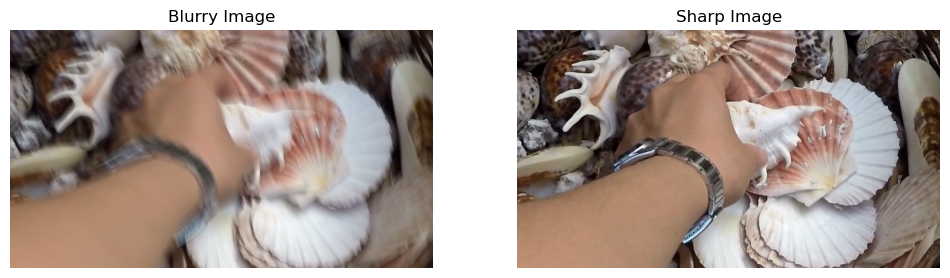

In [6]:
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.axis('off')

# Iterate over data and display images
for blur_images, sharp_images in train_loader:
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    imshow(blur_images[0])
    plt.title('Blurry Image')
    
    plt.subplot(122)
    imshow(sharp_images[0])
    plt.title('Sharp Image')
    plt.show()

    # Optionally, break after the first pair is shown
    break

# **Utility Functions**

In [7]:
def calc_psnr(img1, img2):
    return 10. * torch.log10(1. / torch.mean((img1-img2)**2))

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum/self.count

def weights_init_xavier(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight.data)
        m.bias.data.fill_(0.01)

# **Model**

In [8]:
class AttentionBlock(nn.Module):
    def __init__(self, dim: int):
        super(AttentionBlock, self).__init__()
        self._spatial_attention_conv = nn.Conv2d(2, dim, kernel_size=3, padding=1)

        # Channel attention MLP
        self._channel_attention_conv0 = nn.Conv2d(1, dim, kernel_size=1, padding=0)
        self._channel_attention_conv1 = nn.Conv2d(dim, dim, kernel_size=1, padding=0)

        self._out_conv = nn.Conv2d(2 * dim, dim, kernel_size=1, padding=0)

    def forward(self, x: torch.Tensor):
        if len(x.shape) != 4:
            raise ValueError(f"Expected [B, C, H, W] input, got {x.shape}.")

        # Spatial attention
        mean = torch.mean(x, dim=1, keepdim=True)  # Mean/Max on C axis
        max, _ = torch.max(x, dim=1, keepdim=True)
        spatial_attention = torch.cat([mean, max], dim=1)  # [B, 2, H, W]
        spatial_attention = self._spatial_attention_conv(spatial_attention)
        spatial_attention = torch.sigmoid(spatial_attention) * x

        # Channel attention. TODO: Correct that it only uses average pool contrary to CBAM?
        # NOTE/TODO: This differs from CBAM as it uses Channel pooling, not spatial pooling!
        # In a way, this is 2x spatial attention
        channel_attention = torch.relu(self._channel_attention_conv0(mean))
        channel_attention = self._channel_attention_conv1(channel_attention)
        channel_attention = torch.sigmoid(channel_attention) * x

        attention = torch.cat([spatial_attention, channel_attention], dim=1)  # [B, 2*dim, H, W]
        attention = self._out_conv(attention)
        return x + attention


# TODO: This is not named in the paper right?
# It is sort of the InverseResidualBlock but w/o the Channel and Spatial Attentions and without another Conv after ReLU
class InverseBlock(nn.Module):
    def __init__(self, input_channels: int, channels: int):
        super(InverseBlock, self).__init__()

        self._conv0 = nn.Conv2d(input_channels, channels, kernel_size=1)
        self._dw_conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1, groups=channels)
        self._conv1 = nn.Conv2d(channels, channels, kernel_size=1)
        self._conv2 = nn.Conv2d(input_channels, channels, kernel_size=1)

    def forward(self, x: torch.Tensor):
        features = self._conv0(x)
        features = F.elu(self._dw_conv(features))  # TODO: Paper is ReLU, authors do ELU
        features = self._conv1(features)

        # TODO: The BaseBlock has residuals and one path of convolutions, not 2 separate paths - is this different on purpose?
        x = torch.relu(self._conv2(x))
        return x + features


class BaseBlock(nn.Module):
    def __init__(self, channels: int):
        super(BaseBlock, self).__init__()

        self._conv0 = nn.Conv2d(channels, channels, kernel_size=1)
        self._dw_conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1, groups=channels)
        self._conv1 = nn.Conv2d(channels, channels, kernel_size=1)

        self._conv2 = nn.Conv2d(channels, channels, kernel_size=1)
        self._conv3 = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x: torch.Tensor):
        features = self._conv0(x)
        features = F.elu(self._dw_conv(features))  # TODO: ELU or ReLU?
        features = self._conv1(features)
        x = x + features

        features = F.elu(self._conv2(x))
        features = self._conv3(features)
        return x + features


class AttentionTail(nn.Module):
    def __init__(self, channels: int):
        super(AttentionTail, self).__init__()

        self._conv0 = nn.Conv2d(channels, channels, kernel_size=7, padding=3)
        self._conv1 = nn.Conv2d(channels, channels, kernel_size=5, padding=2)
        self._conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x: torch.Tensor):
        attention = torch.relu(self._conv0(x))
        attention = torch.relu(self._conv1(attention))
        attention = torch.sigmoid(self._conv2(attention))
        return x * attention


class LPIENet(nn.Module):
    def __init__(self, input_channels: int, output_channels: int, encoder_dims: List[int], decoder_dims: List[int]):
        super(LPIENet, self).__init__()

        if len(encoder_dims) != len(decoder_dims) + 1 or len(decoder_dims) < 1:
            raise ValueError(f"Unexpected encoder and decoder dims: {encoder_dims}, {decoder_dims}.")

        if input_channels != output_channels:
            raise NotImplementedError()

        # TODO: We will need an explicit decoder head, consider Unshuffle & Shuffle

        encoders = []
        for i, encoder_dim in enumerate(encoder_dims):
            input_dim = input_channels if i == 0 else encoder_dims[i - 1]
            encoders.append(
                nn.Sequential(
                    nn.Conv2d(input_dim, encoder_dim, kernel_size=3, padding=1),
                    BaseBlock(encoder_dim),  # TODO: one or two base blocks?
                    BaseBlock(encoder_dim),
                    AttentionBlock(encoder_dim),
                )
            )
        self._encoders = nn.ModuleList(encoders)

        decoders = []
        for i, decoder_dim in enumerate(decoder_dims):
            input_dim = encoder_dims[-1] if i == 0 else decoder_dims[i - 1] + encoder_dims[-i - 1]
            decoders.append(
                nn.Sequential(
                    nn.Conv2d(input_dim, decoder_dim, kernel_size=3, padding=1),
                    BaseBlock(decoder_dim),
                    BaseBlock(decoder_dim),
                    AttentionBlock(decoder_dim),
                )
            )
        self._decoders = nn.ModuleList(decoders)

        self._inverse_bock = InverseBlock(encoder_dims[0] + decoder_dims[-1], output_channels)
        self._attention_tail = AttentionTail(output_channels)

    def forward(self, x: torch.Tensor):
        if len(x.shape) != 4:
            raise ValueError(f"Expected [B, C, H, W] input, got {x.shape}.")
        global_residual = x

        encoder_outputs = []
        for i, encoder in enumerate(self._encoders):
            x = encoder(x)
            if i != len(self._encoders) - 1:
                encoder_outputs.append(x)
                x = F.max_pool2d(x, kernel_size=2)

        for i, decoder in enumerate(self._decoders):
            x = decoder(x)
            x = F.interpolate(x, scale_factor=2, mode="bilinear")
            x = torch.cat([x, encoder_outputs.pop()], dim=1)

        x = self._inverse_bock(x)
        x = self._attention_tail(x)
        return x + global_residual

# **Training**

## **Training loop**

In [ ]:
# Connecting to GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Connected to {}".format(device))

In [ ]:
model = LPIENet(3, 3, [16, 32, 64], [32, 16])
model.apply(weights_init_xavier)
model.to(device)
print(model)

In [ ]:
outputDIR = 'Saves/Model_Saves/'

if not os.path.exists(outputDIR):
    os.makedirs(outputDIR)

cudnn.benchmark = True
torch.manual_seed(42)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001) # Edit learning rate here

In [ ]:
best_weights = copy.deepcopy(model.state_dict())
best_epoch = 0
best_psnr = 0.0
num_epochs = 300 # Edit number of epochs here
batch_size = 4
psnrs = []
train_history = []
val_history = [] 

In [ ]:
for epoch in range(num_epochs):
    model.train()
    epoch_losses = AverageMeter()

    with tqdm(total=(len(train_dataset) - len(train_dataset) % batch_size)) as t:
        t.set_description('epoch: {}/{}'.format(epoch+1, num_epochs))
        train_loss = 0.0
        for data in train_loader:
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            preds = model(inputs)

            loss = criterion(preds, labels)

            epoch_losses.update(loss.item(), len(inputs))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()

            t.set_postfix(loss='{:.6f}'.format(epoch_losses.avg))
            t.update(len(inputs))

    torch.save(model.state_dict(), os.path.join(outputDIR, 'epoch_{}.pth'.format(epoch)))

    model.eval()
    epoch_psnr = AverageMeter()
    val_loss = 0
    for data in val_loader:
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            preds = model(inputs)
            loss = criterion(preds, labels)
            val_loss += loss.item()
            preds = preds.clamp(0.0, 1.0)

        epoch_psnr.update(calc_psnr(preds, labels), len(inputs))

    print('train loss: {:.6f}'.format(train_loss/len(train_dataset)))
    print('eval loss: {:.6f}'.format(val_loss/len(val_dataset)))
    print('eval psnr: {:.2f}'.format(epoch_psnr.avg))
    psnrs.append(epoch_psnr.avg.cpu())
    train_history += [train_loss/len(train_dataset)]
    val_history += [val_loss/len(val_dataset)]

    if epoch_psnr.avg > best_psnr:
        best_epoch = epoch
        best_psnr = epoch_psnr.avg
        best_weights = copy.deepcopy(model.state_dict())

print('best epoch: {}, psnr: {:.2f}'.format(best_epoch, best_psnr))
torch.save(best_weights, os.path.join(outputDIR,'best.pth'))

## **Training plots**

In [ ]:
plt.figure()
plt.plot(train_history, 'b',label="trianing loss")
plt.plot(val_history, 'r',label = "validation loss")
plt.title('Convergence plot of gradient descent')
plt.xlabel('Epoch No')
plt.ylabel('J')
plt.legend()
plt.savefig('Saves/Graphs/loss_graph.jpg')
plt.show()

In [ ]:
plt.figure()
plt.plot(psnrs)
plt.title('Convergence plot of PSNR')
plt.xlabel('Epoch No')
plt.ylabel('PSNR')
plt.savefig('Saves/Graphs/psnrs_graph.jpg')
plt.show()

## **Array saves**

In [ ]:
np_psnrs = np.array(psnrs)
np_train_history = np.array(train_history)
np_val_history = np.array(val_history)

np.save('Saves/Arrays/psnrs.npy', np_psnrs)
np.save('Saves/Arrays/val_history.npy',np_val_history)
np.save('Saves/Arrays/train_history.npy',np_train_history)

# **Testing**

## **Loading the best model**

In [9]:
# Connecting to GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Connected to {}".format(device))

Connected to cuda:0


In [10]:
model = LPIENet(3, 3, [16, 32, 64], [32, 16])
model.load_state_dict(torch.load('Saves/Model_Saves/best.pth'))
model.to(device)
print("Model Loaded")

Model Loaded


## **Visualizing the results**

In [11]:
img_path_blur = 'GoPro/test/GOPR0384_11_00/blur/000001.png'
img_path_sharp = 'GoPro/test/GOPR0384_11_00/sharp/000001.png'

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.CenterCrop((540,960)),
    transforms.ToTensor(),
])

img_blur = read_image(img_path_blur, mode=ImageReadMode.RGB)
img_blur = transform(img_blur)

img_sharp = read_image(img_path_sharp, mode=ImageReadMode.RGB)
img_sharp = transform(img_sharp)

In [16]:
p = 1e-5
batch = img_blur.reshape(1, 3, 540, 960)
batch = batch.to(device)
result = model(batch).clip(0, 1-p)

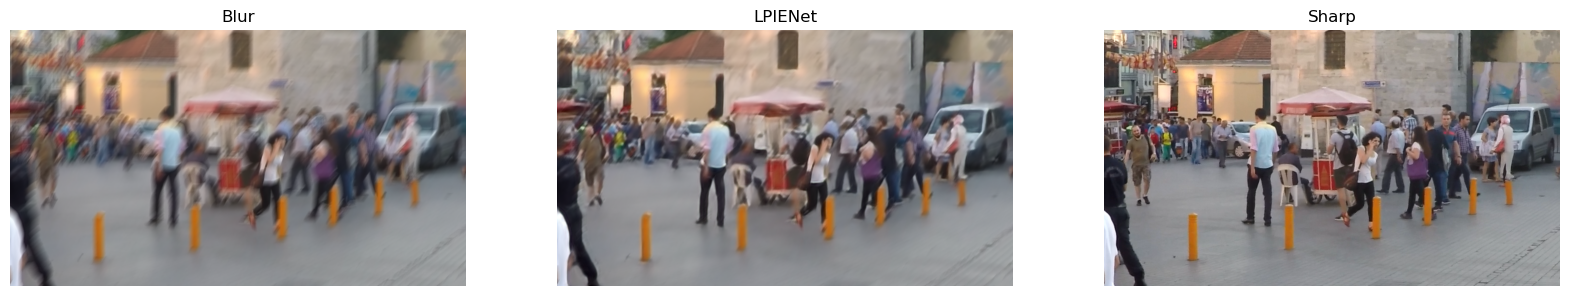

In [17]:
# Plotting the images
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(img_blur.permute(1, 2, 0))
plt.title("Blur")
plt.axis(False)
plt.subplot(132)
plt.imshow(result[0].cpu().permute(1, 2, 0).detach().numpy())
plt.title("LPIENet")
plt.axis(False)
plt.subplot(133)
plt.imshow(img_sharp.permute(1, 2, 0))
plt.title("Sharp")
plt.axis(False)
plt.show()

## **Running on test data**

In [15]:
model.eval()
criteria = nn.MSELoss()
epoch_psnr = AverageMeter()
test_loss = 0
for data in test_loader:
    inputs, labels = data

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        preds = model(inputs)
        loss = criteria(preds, labels)
        test_loss += loss.item()
        preds = preds.clamp(0.0, 1.0)

    epoch_psnr.update(calc_psnr(preds, labels), len(inputs))

print('Test loss: {:.6f}'.format(test_loss/len(test_dataset)))
print('Test psnr: {:.2f}'.format(epoch_psnr.avg))

Test loss: 0.000623
Test psnr: 26.93
